In [1]:
import os
import mlflow
from pyspark.sql.functions import struct, col
import mlflow.pyfunc

os.environ["AWS_ACCESS_KEY_ID"] = "minioadmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minioadmin"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://sparkjupyter-minio-1:9000"

rnn_model = mlflow.pyfunc.load_model(model_uri=f"s3://mlflow/artifacts/0/adfc4f58c8e64b38bd8a07cd36256104/artifacts/rnn_model")

2023/07/03 18:57:51 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - boto3 (current: 1.26.163, required: boto3==1.26.151)
 - protobuf (current: 4.23.3, required: protobuf==4.23.2)
 - scipy (current: 1.11.1, required: scipy==1.10.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2023-07-03 18:57:52.018456: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 18:57:52.145893: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 18:57:52.148159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, i

In [2]:
import pandas as pd
test_input = pd.read_csv('./test_input_rnn.csv',index_col=None)

In [3]:
test_label = pd.read_csv('./test_label_rnn.csv',index_col=None)

In [4]:
test_input.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,80,81,82,83,84,85,86,87,88,89
0,0,0.083333,0.944079,0.0,0.020833,0.947368,0.0,0.083333,0.944079,0.0,...,0.0,0.125000,0.953947,0.0,0.020833,0.953947,0.0,0.375000,0.953947,0.0
1,1,0.041667,0.947368,0.0,0.104167,0.947368,0.0,0.020833,0.947368,0.0,...,0.0,0.104167,0.861842,0.0,0.354167,0.865132,0.0,0.208333,0.871711,0.0
2,2,0.145833,0.947368,0.0,0.104167,0.947368,0.0,0.104167,0.944079,0.0,...,0.0,0.187500,0.953947,0.0,0.291667,0.953947,0.0,0.375000,0.953947,0.0
3,3,0.041667,0.947368,0.0,0.104167,0.947368,0.0,0.229167,0.947368,0.0,...,0.0,0.062500,0.953947,0.0,0.000000,0.967105,0.0,0.395833,0.898026,0.0
4,4,0.208333,0.944079,0.0,0.791667,0.947368,0.0,0.500000,0.947368,0.0,...,0.0,0.041667,0.947368,0.0,0.000000,0.950658,0.0,0.041667,0.947368,0.0


In [5]:
test_input.shape

(32, 91)

In [6]:
import numpy as np
batch_size = 32
input_steps = 30
output_steps = 30
n_total_features = int((test_input.shape[1]-1)/input_steps)
test_input_np = np.array(test_input)[:,1:].reshape((batch_size,input_steps,n_total_features))
test_label_np = np.array(test_label)[:,1:].reshape((batch_size,output_steps,1))

In [7]:
predictions = rnn_model.predict(test_input_np)

1/1 [==============================] - 0s 316ms/step


In [8]:
predictions

array([[[ 1.04280315e-01],
        [ 1.17985897e-01],
        [ 6.53094053e-02],
        [ 7.97670633e-02],
        [ 1.71655536e-01],
        [ 1.14597403e-01],
        [-3.43475118e-03],
        [ 3.54707986e-03],
        [ 5.50764501e-02],
        [ 3.81195210e-02],
        [-3.86257954e-02],
        [-4.68250960e-02],
        [-4.65293229e-03],
        [ 1.16748393e-01],
        [ 1.96864083e-01],
        [ 1.01016209e-01],
        [ 2.14532062e-01],
        [ 1.77833170e-01],
        [ 1.25379771e-01],
        [ 2.52321988e-01],
        [ 2.52775460e-01],
        [ 2.54956096e-01],
        [ 2.29810238e-01],
        [ 9.67083126e-02],
        [ 3.29680517e-02],
        [-5.47224283e-03],
        [-3.60229798e-02],
        [-2.54462101e-02],
        [-4.44775894e-02],
        [-2.49199234e-02]],

       [[ 8.33088309e-02],
        [ 5.64046092e-02],
        [ 1.21738404e-01],
        [ 1.38737231e-01],
        [ 2.00878114e-01],
        [ 1.79300487e-01],
        [ 1.02459937e-01],

In [9]:
def mse(y_true, y_pred):
    return np.square(y_true - y_pred).mean()

mse_rnn_test = mse(test_label_np, predictions)
print('mse on test data is :',mse_rnn_test)

mse on test data is : 0.04179783532009152


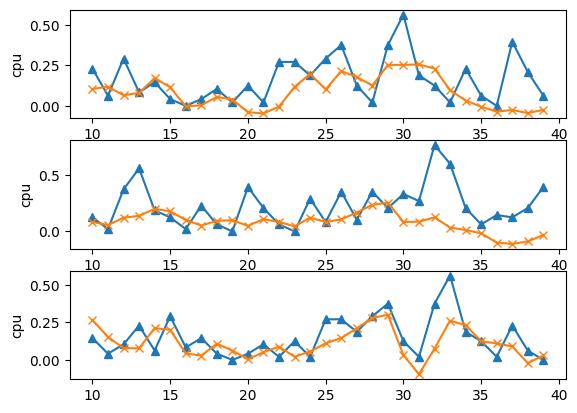

In [10]:
import matplotlib.pyplot as plt
max_subplots = 3
plot_col = 'cpu'
max_n = max_subplots
shift = 10
input_indices = np.arange(predictions.shape[1])
label_indices = np.arange(shift,predictions.shape[1]+shift,1)
for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(label_indices, test_label_np[n, :, 0],
                marker='^', label='Labels')
    plt.plot(label_indices,  predictions[n, :, 0],
                label='prediction', marker='x')